In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

In [4]:
sns.set(style='whitegrid')
sns.set_palette("pastel")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# Statistics

In [3]:
# 1. Ekman 감정군 정의
emotion_groups_ekman = {
    'joy': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
    'neutral': ['neutral']
}

In [4]:
# 2. 감정군 집계 함수
def process_platform_emotions(df, date_col):
    """
    주어진 DataFrame에서 날짜 컬럼을 기준으로 주 단위 Ekman 감정 평균을 계산합니다.

    Returns:
        pd.DataFrame: 주(week)별 6가지 Ekman 감정 평균 점수를 포함하는 데이터프레임.
                      'week' 컬럼과 Ekman 감정 컬럼들을 포함.
                      오류 발생 시 빈 DataFrame 반환.
    """        
    # 원본 데이터프레임 복사하여 작업 (원본 보존)
    df_processed = df.copy()

    # 날짜 변환 및 주 단위 추출
    df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce').dt.tz_localize(None)
    df_processed = df_processed.dropna(subset=[date_col])
    df_processed['week'] = df_processed[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    # Ekman 감정군 계산
    missing_emotions = []
    for group, emotions in emotion_groups_ekman.items():
        # 원본 데이터에 있는 감정 컬럼만 필터링
        valid_emotions = [e for e in emotions if e in df_processed.columns]
        if not valid_emotions:
            missing_emotions.append(group)
            df_processed[group] = np.nan # 해당하는 세부 감정이 하나도 없으면 NaN 처리
            continue
            
        # 존재하는 감정 컬럼들의 평균 계산
        df_processed[group] = df_processed[valid_emotions].mean(axis=1)

    if missing_emotions:
        print(f"경고: 다음 Ekman 그룹에 해당하는 세부 감정 컬럼이 원본 데이터에 없어 NaN으로 처리됩니다: {missing_emotions}")

    # 주 단위 감정군 평균 집계
    ekman_cols = list(emotion_groups_ekman.keys())
    weekly_df = df_processed.groupby('week')[ekman_cols].mean().reset_index()
    
    return weekly_df

In [5]:
public_df = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil_df = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

# 주 단위 Ekman 감정 집계
weekly_public = process_platform_emotions(public_df, 'pub_date')
weekly_civil = process_platform_emotions(civil_df, 'pub_date')

# --- 기술 통계량 계산 ---
if not weekly_public.empty and not weekly_civil.empty:
    stats_public = weekly_public[list(emotion_groups_ekman.keys())].describe()
    stats_civil = weekly_civil[list(emotion_groups_ekman.keys())].describe()

    # 두 플랫폼 통계량 합치기 (보기 좋은 테이블 형태 구성)
    # 컬럼을 MultiIndex로 구성: (Platform, Statistic)
    stats_combined = pd.concat(
        [stats_public, stats_civil],
        axis=1,  # 컬럼 방향으로 합치기
        keys=['Public Media', 'Civil Platform']  # 최상위 컬럼 레벨 이름 지정
    ).swaplevel(0, 1, axis=1).sort_index(axis=1)  # 플랫폼별로 통계량 묶이도록 컬럼 레벨 변경 및 정렬

    # 감정을 인덱스로 변경 (더 보기 좋게)
    stats_final = stats_combined.T  # Transpose: 감정이 인덱스로, 통계량이 컬럼으로

    print("--- 주 단위 Ekman 감성 점수 기술 통계량 ---")
    display(stats_final.style.format("{:.2f}"))  # 소수점 4자리까지 표시하도록 스타일 적용 (표시용)

else:
    print("오류")

--- 주 단위 Ekman 감성 점수 기술 통계량 ---


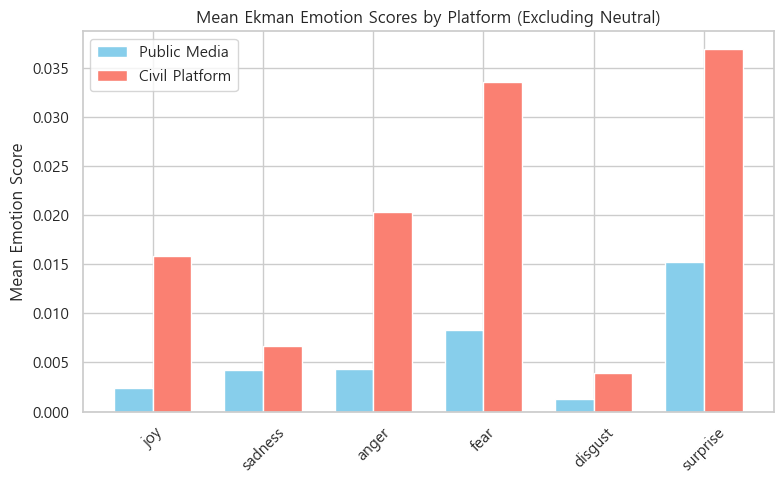

In [6]:
# 'neutral' 감정 제거
emotions_no_neutral = [e for e in emotion_groups_ekman.keys() if e.lower() != 'neutral']

# 평균 점수 추출
avg_public = stats_public.loc['mean', emotions_no_neutral]
avg_civil = stats_civil.loc['mean', emotions_no_neutral]

# x 위치 설정
x = np.arange(len(emotions_no_neutral))
bar_width = 0.35

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, avg_public, width=bar_width, label='Public Media', color='skyblue')
plt.bar(x + bar_width/2, avg_civil, width=bar_width, label='Civil Platform', color='salmon')

# 눈금 및 라벨 설정
plt.xticks(x, emotions_no_neutral, rotation=45)
plt.ylabel("Mean Emotion Score")
plt.title("Mean Ekman Emotion Scores by Platform (Excluding Neutral)")
plt.legend()
plt.tight_layout()
plt.show()

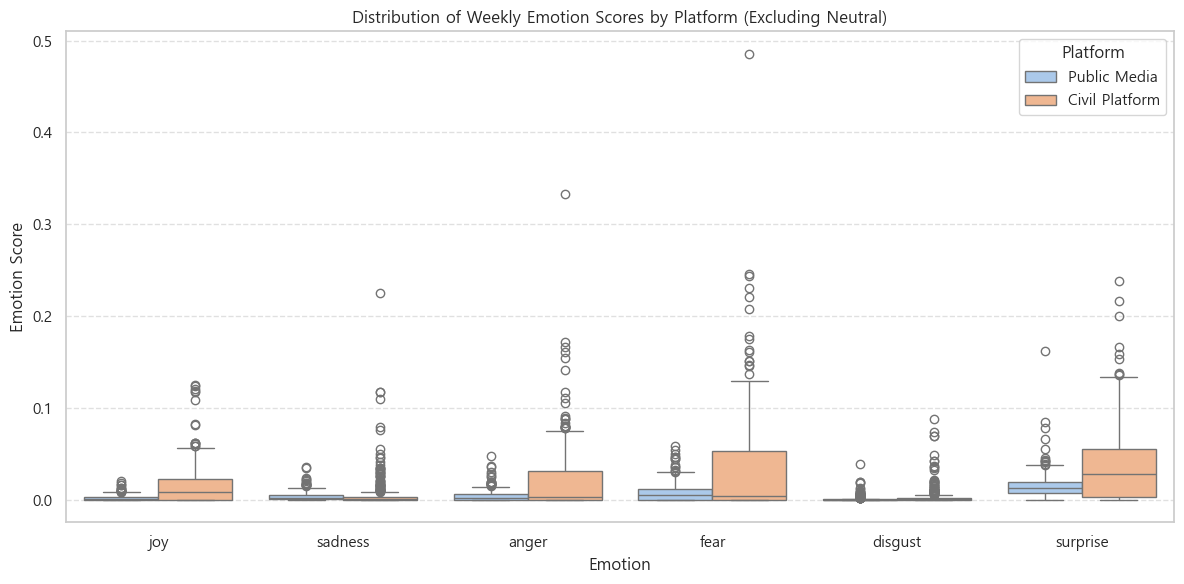

In [7]:
# weekly 데이터 병합 후 감정별 비교
weekly_public['Platform'] = 'Public Media'
weekly_civil['Platform'] = 'Civil Platform'

merged_weekly = pd.concat([weekly_public, weekly_civil], ignore_index=True)
melted = merged_weekly.melt(id_vars=['week', 'Platform'], value_vars=list(emotion_groups_ekman.keys()),
                            var_name='Emotion', value_name='Score')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted[melted['Emotion'] != 'neutral'], x='Emotion', y='Score', hue='Platform')
plt.title("Distribution of Weekly Emotion Scores by Platform (Excluding Neutral)")
plt.ylabel("Emotion Score")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# T-Test

In [8]:
from scipy.stats import ttest_ind

ttest_results = []

for emo in list(emotion_groups_ekman.keys()):
    #if emo == 'neutral':
    #    continue
    group1 = weekly_public[emo].dropna()
    group2 = weekly_civil[emo].dropna()
    
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    
    ttest_results.append({
        'emotion': emo,
        't_stat': round(t_stat, 3),
        'p_value': round(p_val, 5),
        'significant': '✅' if p_val < 0.05 else '❌'
    })

ttest_df = pd.DataFrame(ttest_results)
print("\n--- 감정별 Public vs Civil Platform 평균 차이 t-test 결과 ---")
display(ttest_df)


--- 감정별 Public vs Civil Platform 평균 차이 t-test 결과 ---


,emotion,t_stat,p_value,significant
0,joy,-11.239,0.00000,✅
1,sadness,-2.235,0.02601,✅
2,anger,-8.093,0.00000,✅
3,fear,-8.285,0.00000,✅
4,disgust,-4.427,0.00001,✅
5,surprise,-9.091,0.00000,✅
6,neutral,33.560,0.00000,✅


# Decay Rate

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [37]:
emotion_groups_ekman = {
    'joy': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
}

In [41]:
def exp_decay(t, A, k):
    return A * np.exp(-k * t)

def segment_decay_fit(y, prominence=0.005, window=10, plot_title="Segment Decay Fitting"):
    t = np.arange(len(y))
    peaks, _ = find_peaks(y, prominence=prominence)
    decay_rates, peak_indices = [], []

    plt.figure(figsize=(15, 8))
    plt.plot(t, y, label='Original Signal', color='gray')

    for peak in peaks:
        t_seg = np.arange(window)
        y_seg = y[peak:peak + window]
        if len(y_seg) < window or np.any(np.isnan(y_seg)):
            continue
        try:
            params, _ = curve_fit(exp_decay, t_seg, y_seg, p0=(y_seg[0], 0.1), maxfev=10000)
            A, k = params
            if k > 0:
                decay_rates.append(k)
                peak_indices.append(peak)
                plt.plot(peak + t_seg, exp_decay(t_seg, *params), label=f'Emotion: {plot_title}, Peak@{peak}, k={k:.3f}')
        except:
            continue

    plt.title(f"{plot_title} - Emotion Decay")
    plt.xlabel("Time Index")
    plt.ylabel("Emotion Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "peak_index": peak_indices,
        "decay_rate_k": decay_rates,
        "half_life_weeks": [np.log(2) / k if k > 0 else np.nan for k in decay_rates]
    })

def process_platform_emotions_monthly_smoothed(path, date_col, window=3):
    df = pd.read_csv(path)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)
    
    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)
    
    monthly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    
    for group in emotion_groups_ekman.keys():
        monthly_df[group] = monthly_df[group].rolling(window=window, min_periods=1).mean()
    
    return monthly_df

def analyze_all_emotions(weekly_df, platform_label):
    all_results = []
    for emotion in emotion_groups_ekman.keys():
        decay_df = segment_decay_fit(weekly_df[emotion].values, prominence=0.002, window=12, plot_title=emotion)
        decay_df["emotion"] = emotion
        decay_df["platform"] = platform_label
        all_results.append(decay_df)
    return pd.concat(all_results, ignore_index=True)

def remove_outliers_iqr(df, col='half_life_weeks'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)].copy()

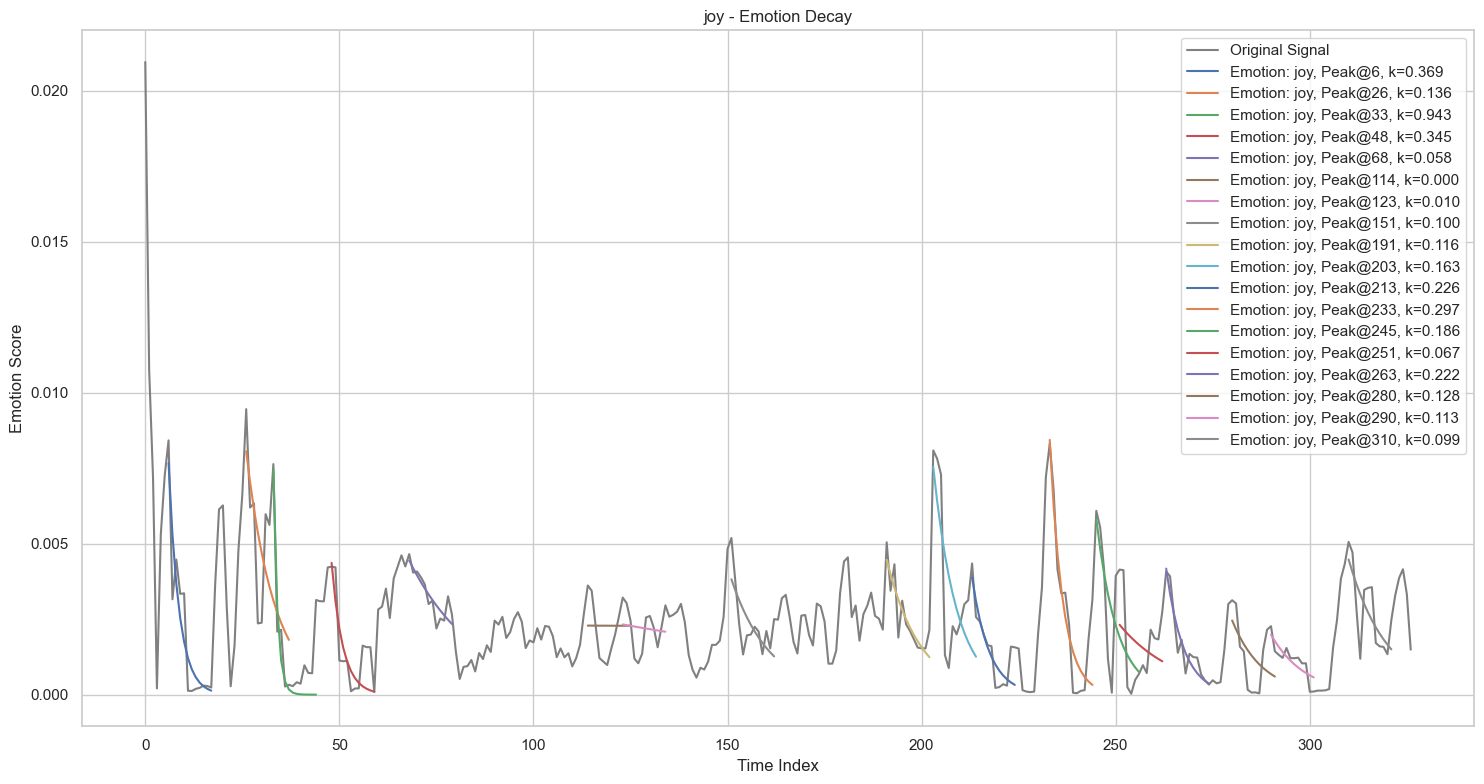

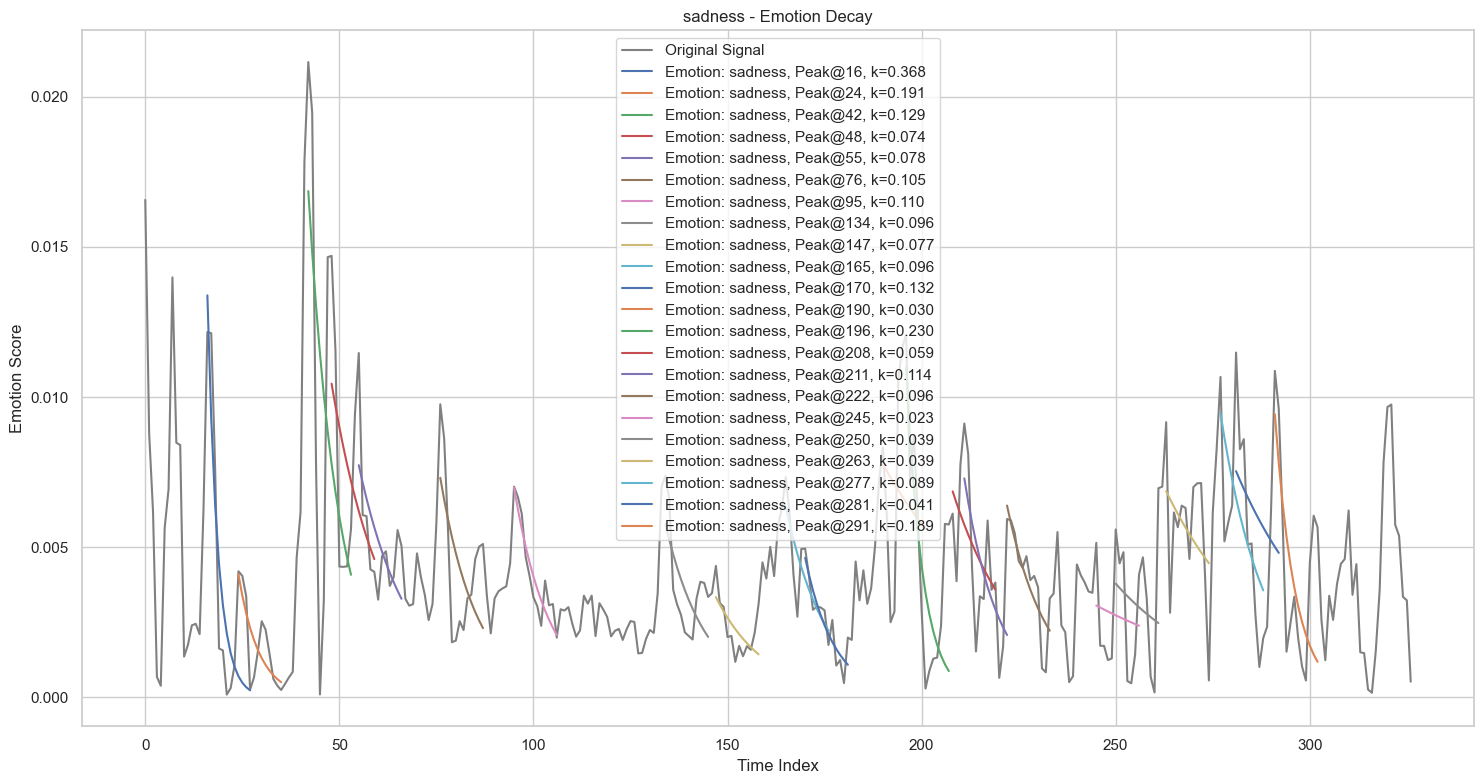

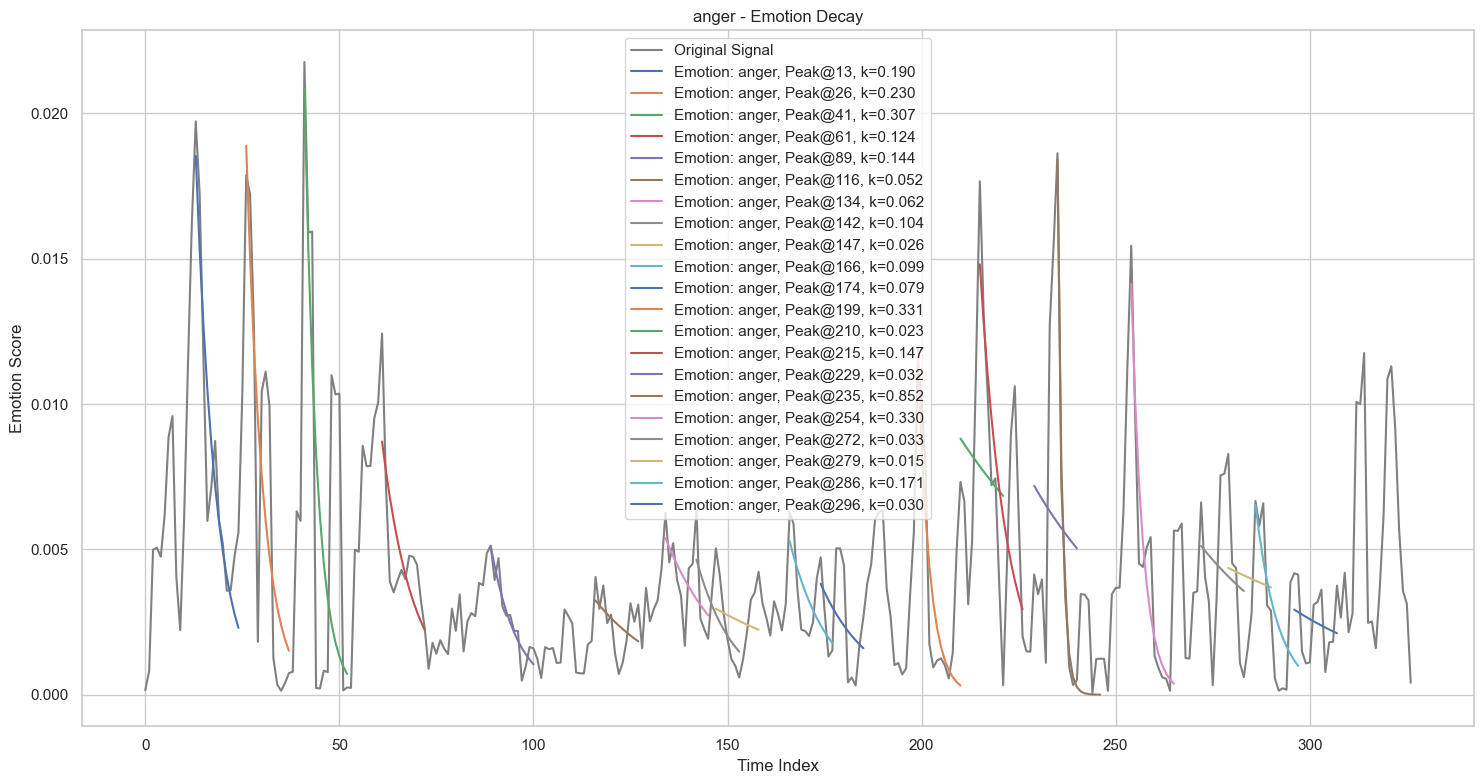

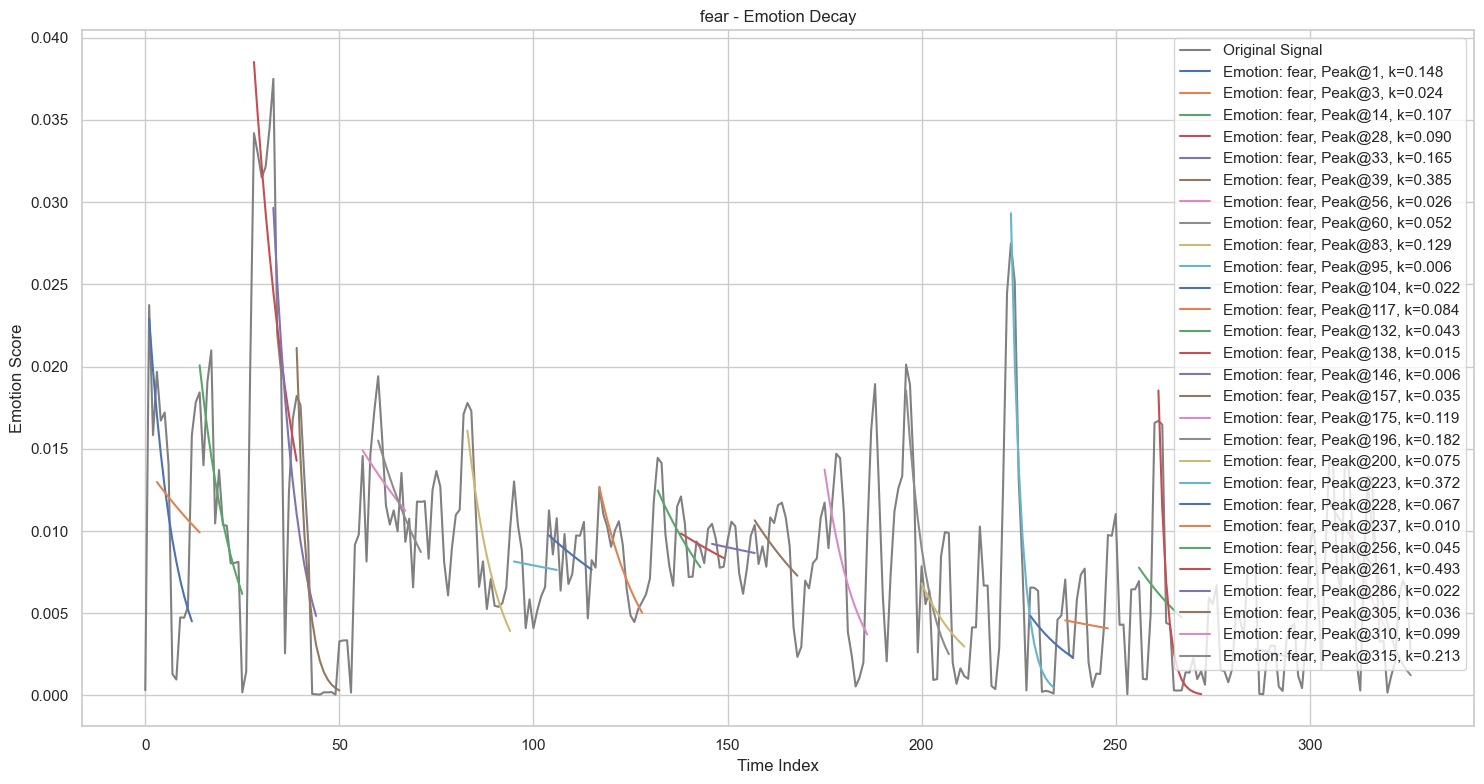

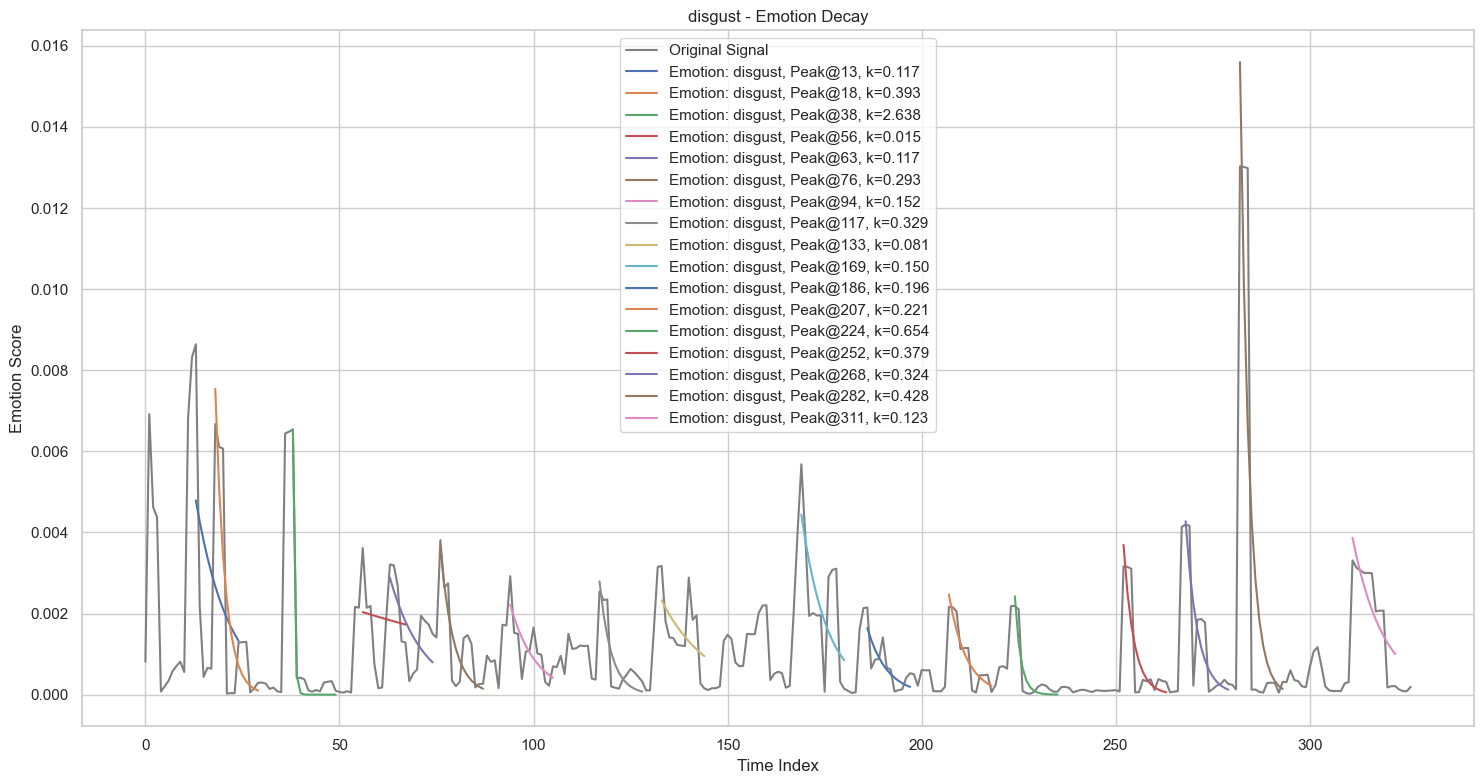

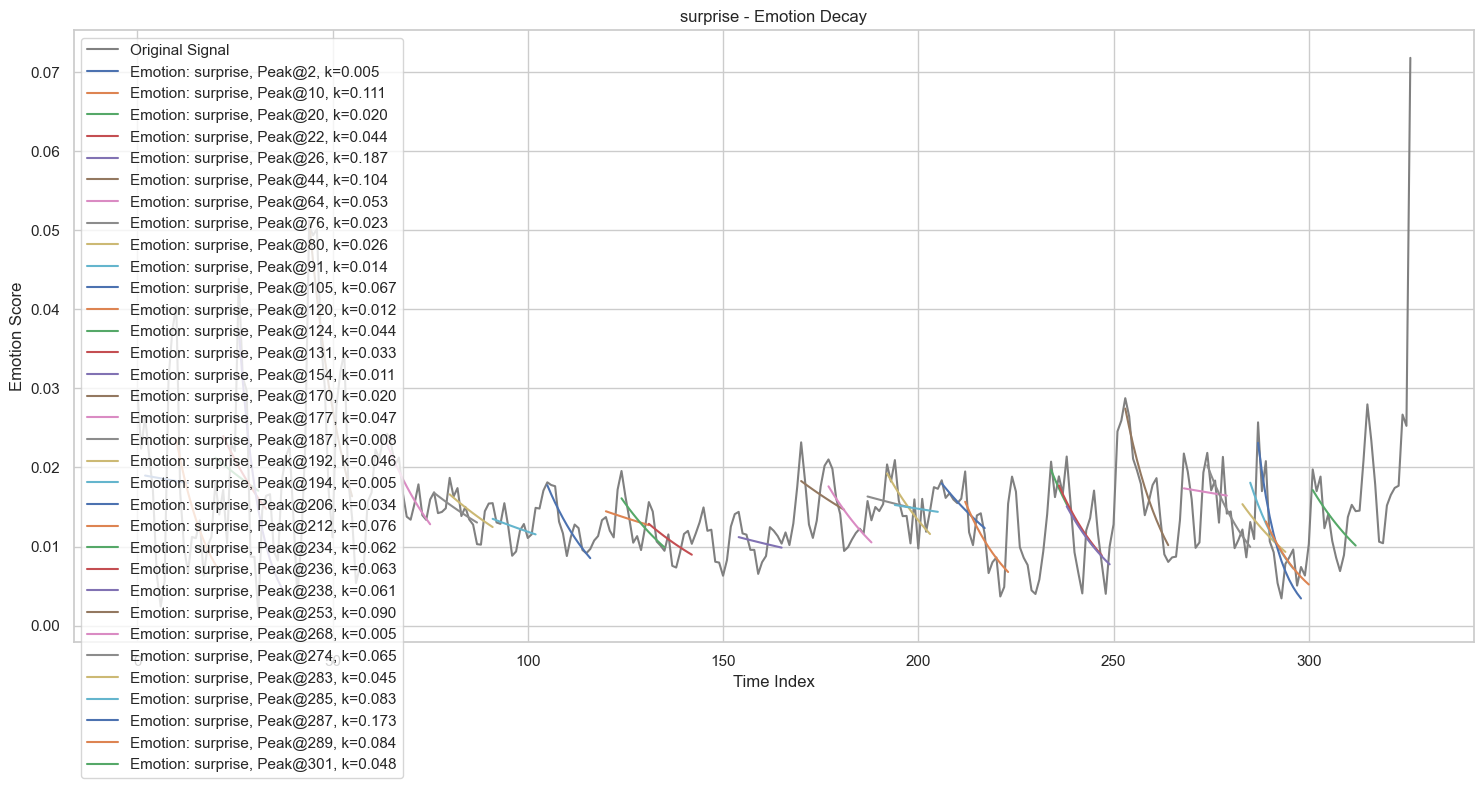

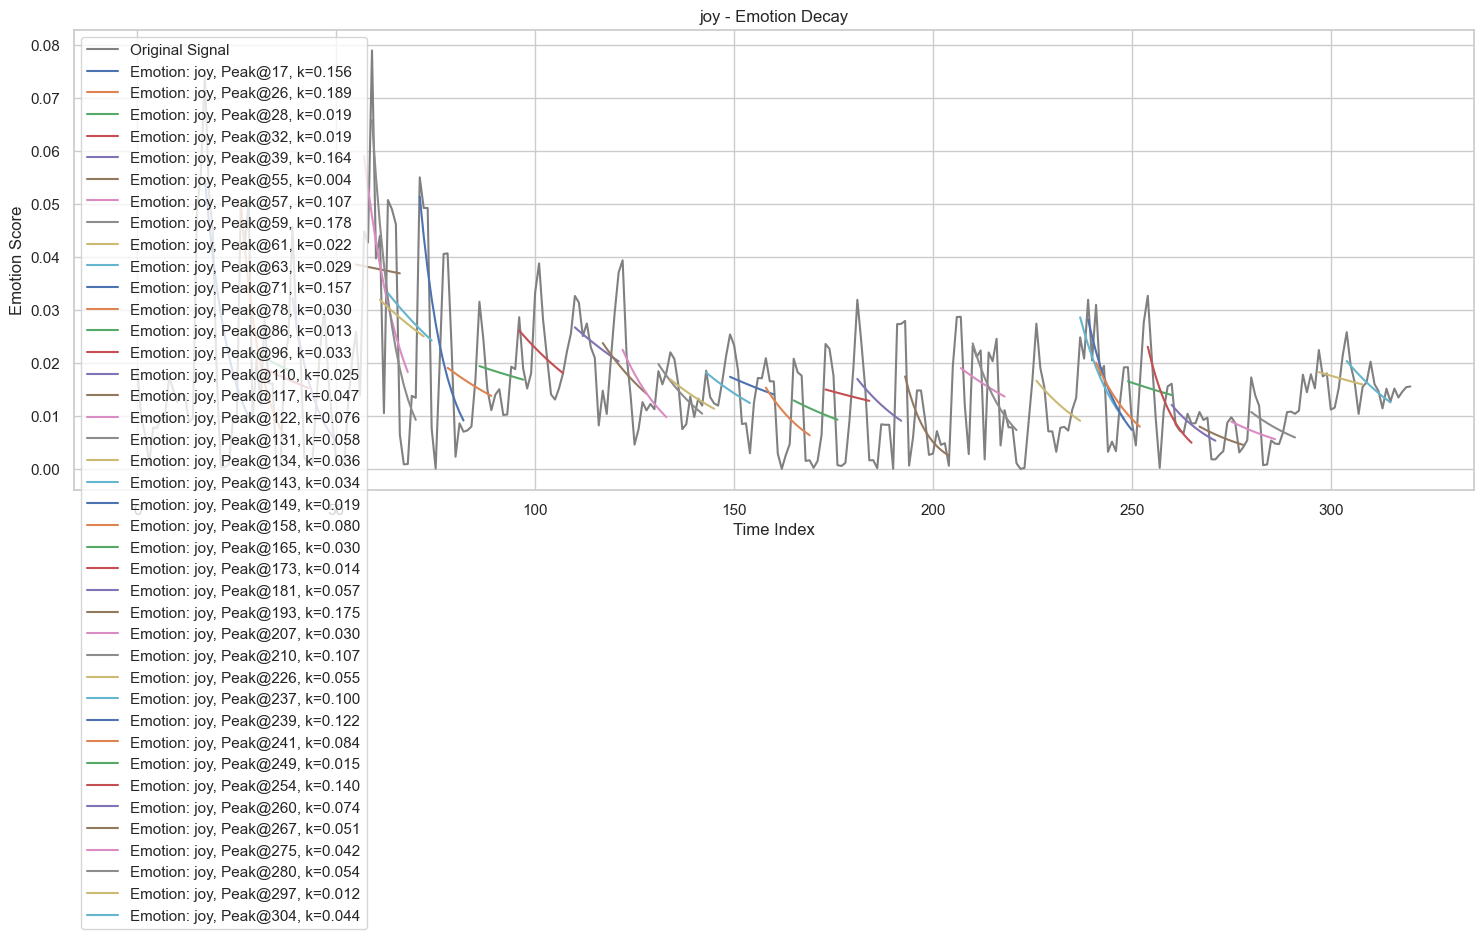

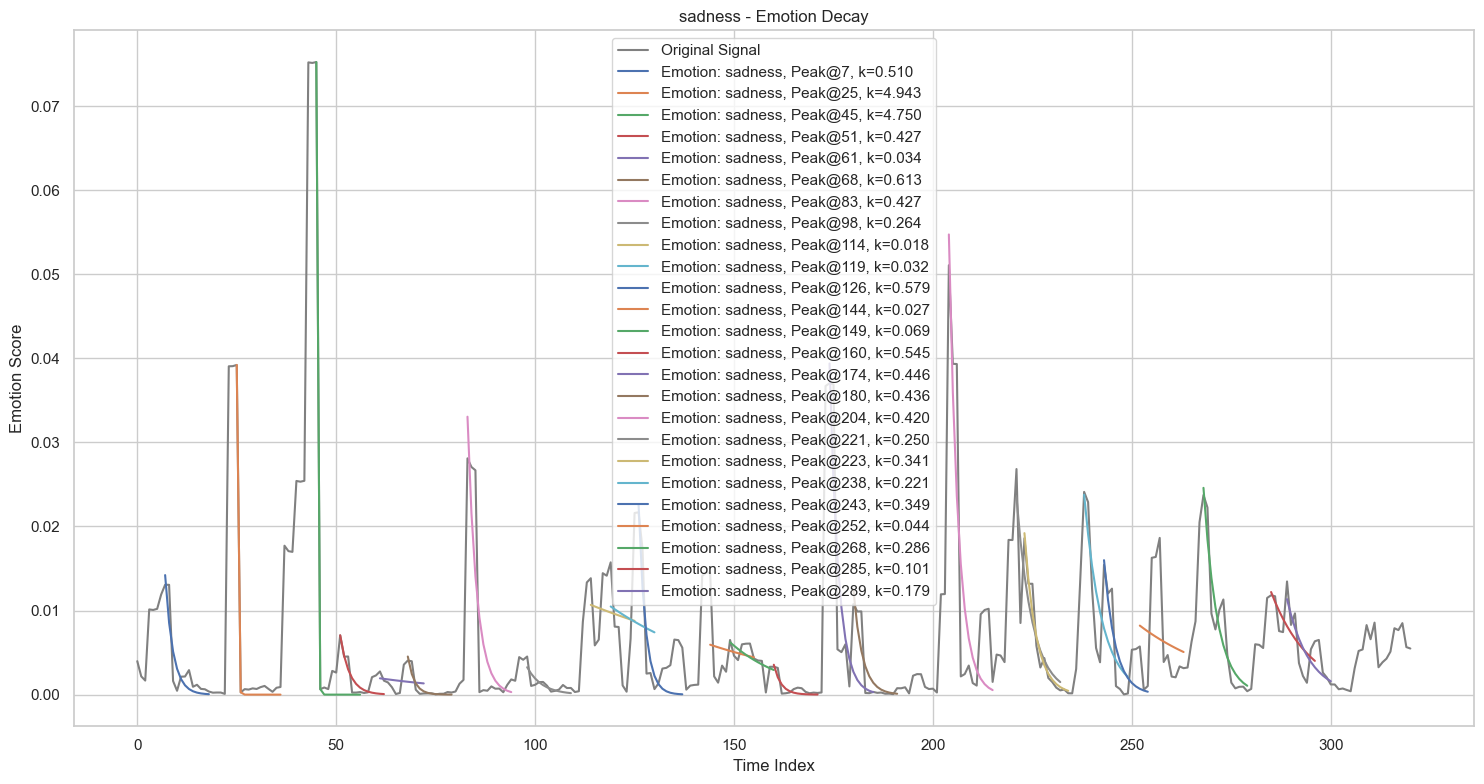

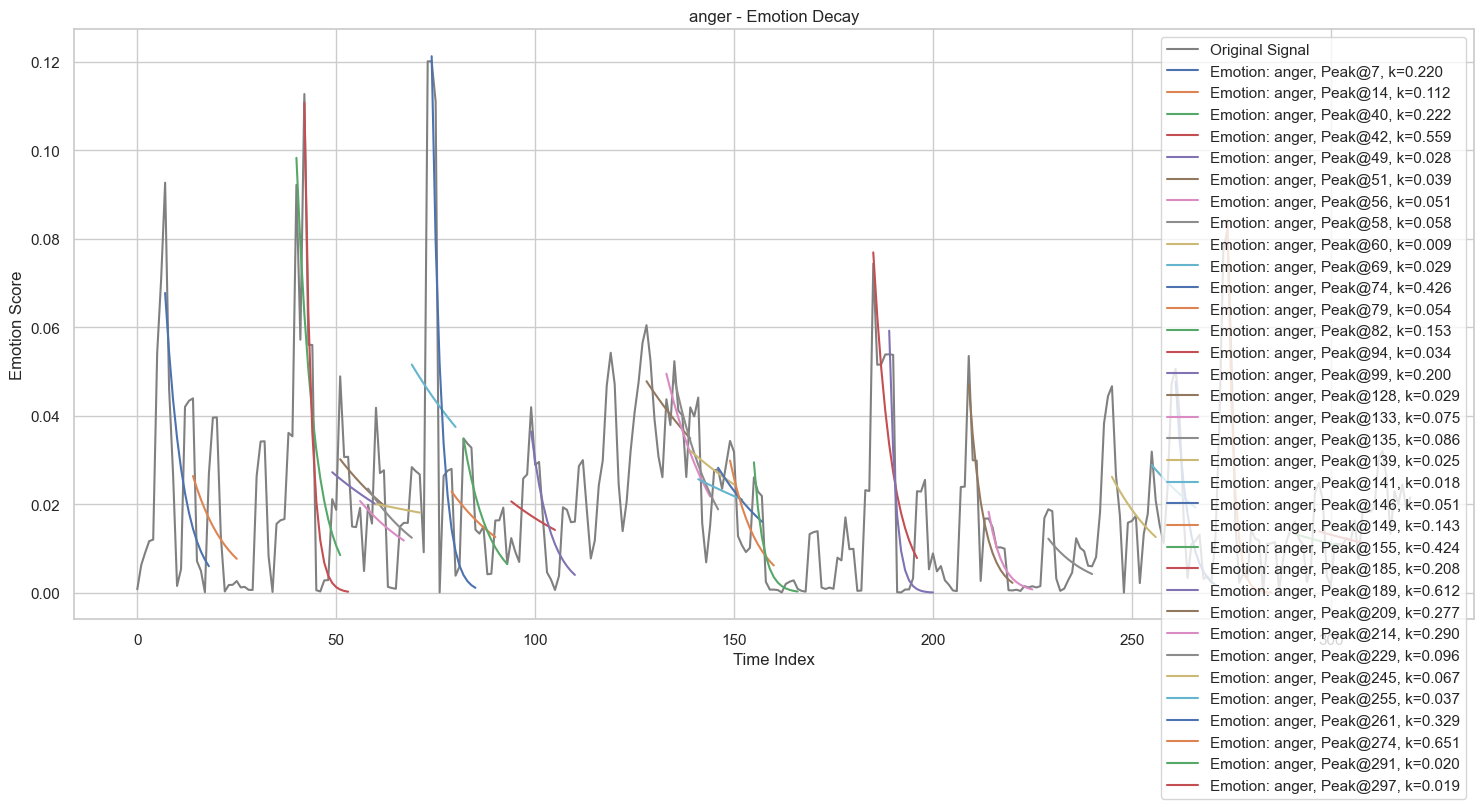

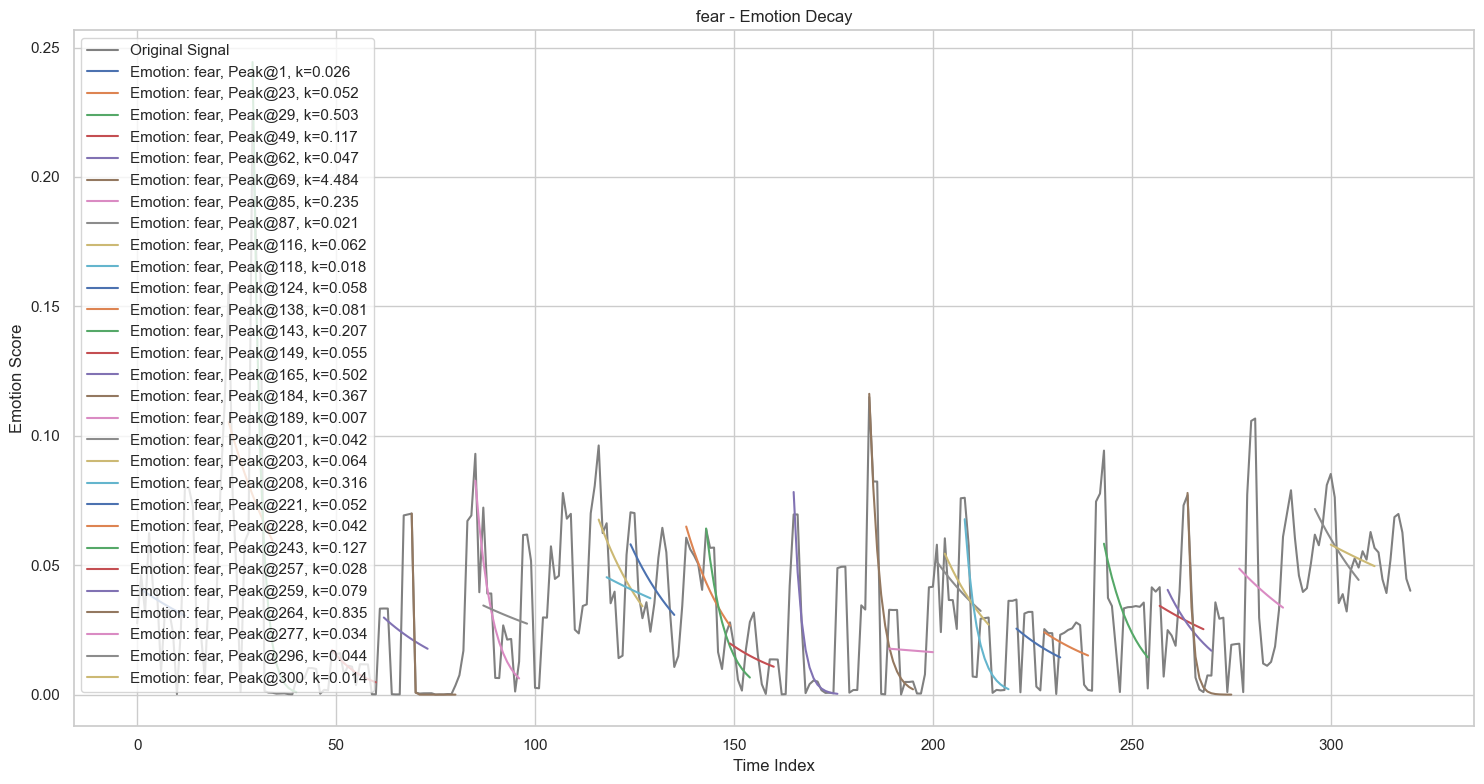

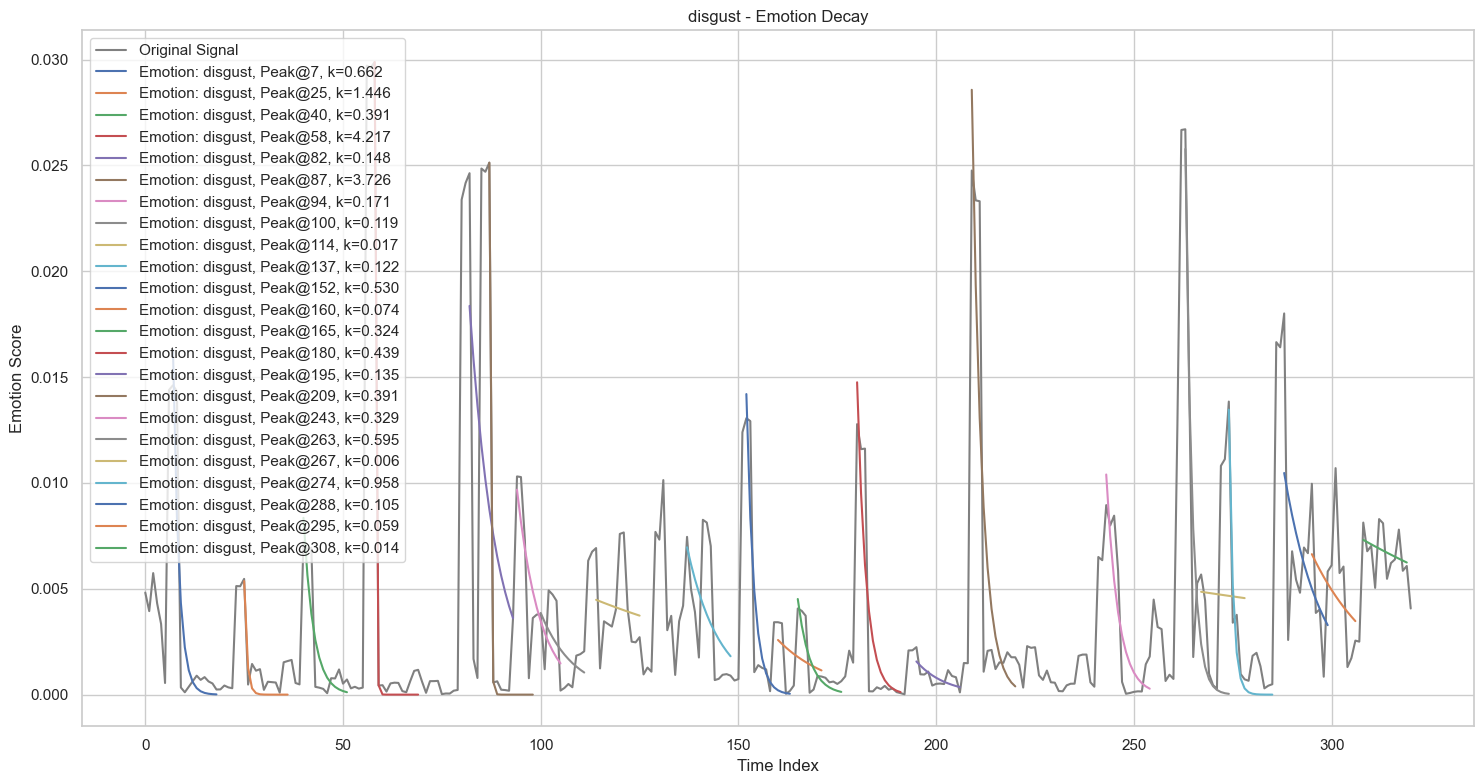

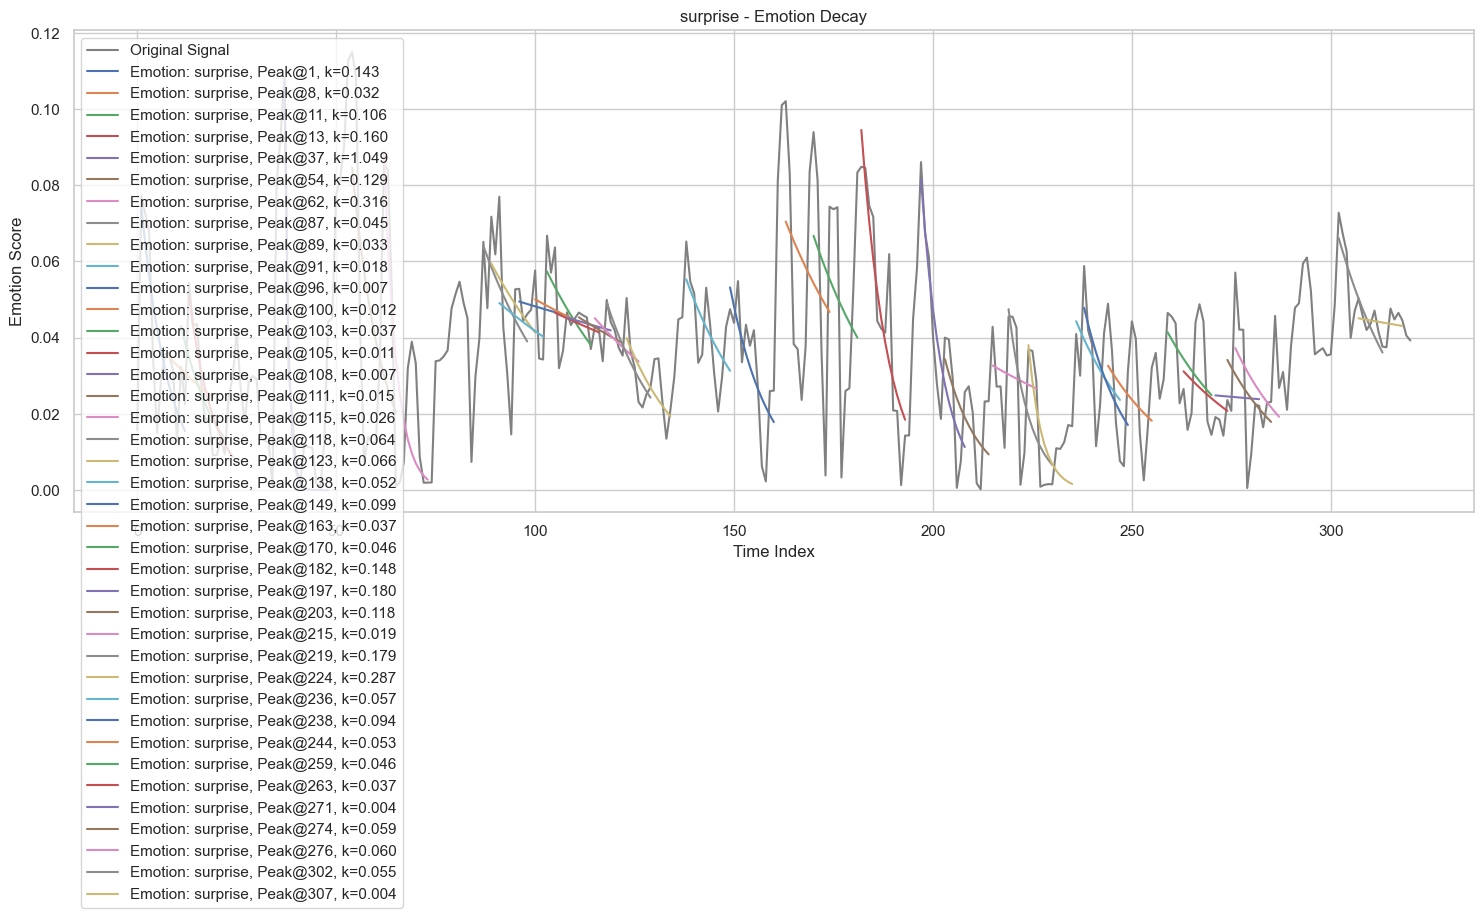

In [42]:
# 파일 로드 및 처리
smoothed_public = process_platform_emotions_monthly_smoothed('./ready/public_media_vaccine.csv', 'pub_date')
smoothed_civil = process_platform_emotions_monthly_smoothed('./ready/civil_platform_vaccine.csv', 'pub_date')

# 전체 감정 분석
summary_public = analyze_all_emotions(smoothed_public, "Public Media")
summary_civil = analyze_all_emotions(smoothed_civil, "Civil Platform")
summary_all = pd.concat([summary_public, summary_civil], ignore_index=True)

summary_filtered = remove_outliers_iqr(summary_all)

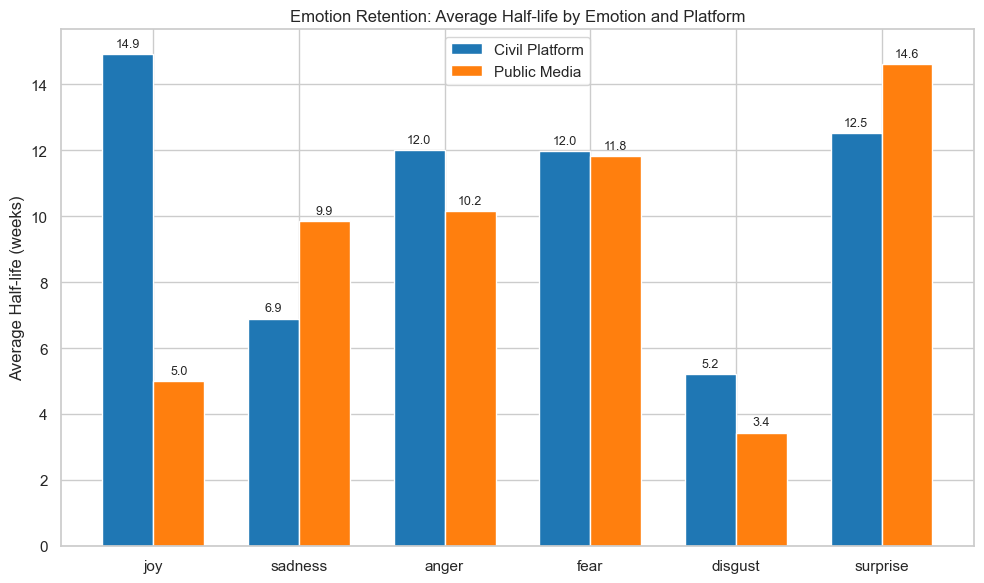

In [43]:
# 평균 half-life 계산
mean_half_life = summary_filtered.groupby(['emotion', 'platform'])['half_life_weeks'].mean().reset_index()

# 시각화 코드
sns.set(style="whitegrid")
emotion_order = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
mean_half_life["emotion"] = pd.Categorical(mean_half_life["emotion"], categories=emotion_order, ordered=True)
mean_half_life = mean_half_life.sort_values(["emotion", "platform"])

pivot = mean_half_life.pivot(index="emotion", columns="platform", values="half_life_weeks")
platforms = pivot.columns.tolist()
x = np.arange(len(pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pivot[platforms[0]], width, label=platforms[0], color="#1f77b4")
bars2 = ax.bar(x + width/2, pivot[platforms[1]], width, label=platforms[1], color="#ff7f0e")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_ylabel("Average Half-life (weeks)")
ax.set_title("Emotion Retention: Average Half-life by Emotion and Platform")
ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.legend()
plt.tight_layout()
plt.show()

# Auto Correlation

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
emotion_groups_ekman = {
    'joy': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
}

In [9]:
def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

def compute_autocorrelation(df, platform_name):
    results = []
    for emotion in emotion_groups:
        series = df[emotion]
        if series.isnull().sum() > 0:
            series = series.dropna()

        if len(series) > 1:
            autocorr = series.autocorr(lag=1)
        else:
            autocorr = None

        results.append({
            'platform': platform_name,
            'emotion': emotion,
            'autocorrelation_lag1': autocorr
        })
    return pd.DataFrame(results)

In [10]:
emotion_groups = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')

weekly_civil_smoothed = weekly_civil.copy()
for emotion in emotion_groups:
    weekly_civil_smoothed[emotion] = weekly_civil[emotion].rolling(window=3, center=True).mean()
weekly_civil_smoothed = weekly_civil_smoothed.dropna()

autocorr_public = compute_autocorrelation(weekly_public, 'Public Media')
autocorr_civil = compute_autocorrelation(weekly_civil_smoothed, 'Civil Platform')

autocorr_results = pd.concat([autocorr_public, autocorr_civil], ignore_index=True)

print("\n[AutoCorrelation Results]")
print(autocorr_results)


[AutoCorrelation Results]
          platform   emotion  autocorrelation_lag1
0     Public Media       joy              0.035944
1     Public Media   sadness              0.091713
2     Public Media     anger              0.087751
3     Public Media      fear              0.129912
4     Public Media   disgust             -0.039078
5     Public Media  surprise              0.040214
6   Civil Platform       joy              0.637441
7   Civil Platform   sadness              0.687540
8   Civil Platform     anger              0.672790
9   Civil Platform      fear              0.654907
10  Civil Platform   disgust              0.619698
11  Civil Platform  surprise              0.684321


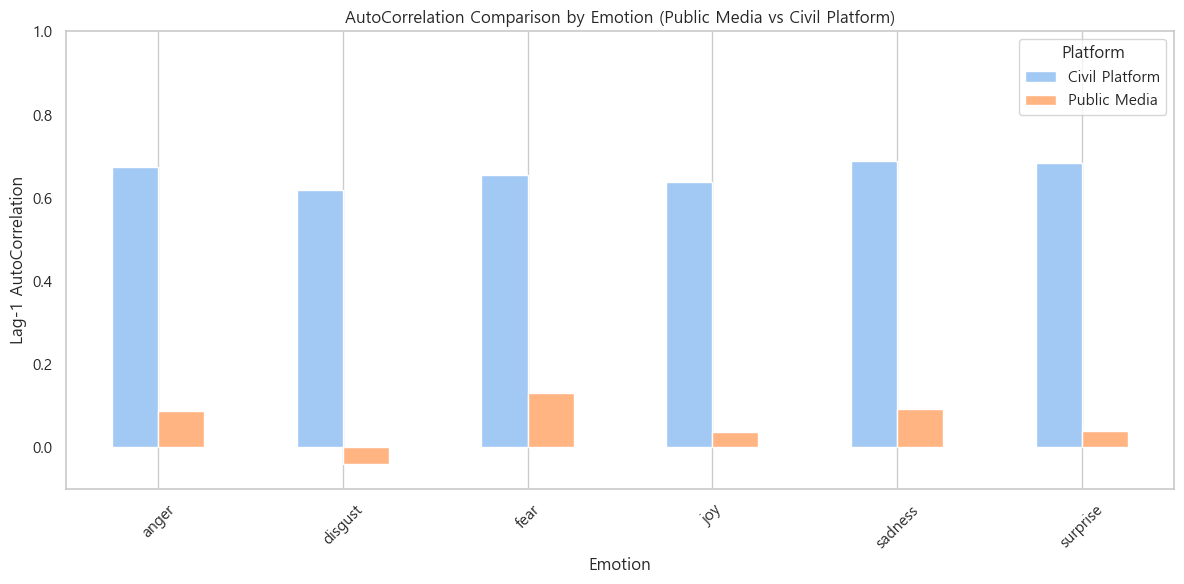

In [11]:
pivot_autocorr = autocorr_results.pivot(index='emotion', columns='platform', values='autocorrelation_lag1')

pivot_autocorr.plot(kind='bar', figsize=(12, 6))

plt.title('AutoCorrelation Comparison by Emotion (Public Media vs Civil Platform)')
plt.xlabel('Emotion')
plt.ylabel('Lag-1 AutoCorrelation')
plt.xticks(rotation=45)
plt.ylim(-0.1, 1.0)
plt.grid(axis='y')
plt.legend(title='Platform')
plt.tight_layout()
plt.show()